In [2]:
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import pyrtools as pt
from tqdm import tqdm 
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
from utils.image_treatment import preprocess_image, image_to_distribution
import matplotlib.pyplot as plt
import pickle
import ot
from joblib import Parallel, delayed

/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'

In [4]:
image1 = preprocess_image(image_path1, new_size = (75,75))
image2 = preprocess_image(image_path2, new_size = (75,75))
textures = [image1, image2]

In [63]:
def compute_sliced_wass_barycenter(distributions, rho = None, lr = 1e3, k = 200, nb_iter_max = 50, xbinit = None):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    distributions = [x.astype(np.float64) for x in distributions]
    x_torch = [torch.tensor(x).to(device=device) for x in distributions]
    #print(distributions[0].dtype)

    if rho is None: 
        n = len(distributions)
        rho = n*[1/n]
    
    if xbinit is None:
        #xbinit = np.random.randn(500, 2) * 10 + 16 #initialization
        xbinit = np.random.normal(0., 1., distributions[0].shape)
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)
    #print(xbinit.dtype)


    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], xbary_torch.shape[1]))

    loss_iter = []

    # generator for random permutations
    gen = torch.Generator(device=device)
    gen.manual_seed(42)


    for i in range(nb_iter_max):

        loss = 0
        for i, x in enumerate(x_torch):
            loss += rho[i] * ot.sliced_wasserstein_distance(xbary_torch, x, n_projections=50, seed=gen)
        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()

    xb = xbary_torch.clone().detach().cpu().numpy()
    return(xb)

### Pyramid

In [6]:
def initialize_random_image(size=(256, 256), channels=3):
    """Initialize a random white noise image f^(0)."""
    return np.random.rand(*size, channels)

In [44]:
def projection(X0, Y, nb_iter_max=1000):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_sliced_wass_barycenter(Y_distrib, rho = None, lr = 1e3, k = 200,  nb_iter_max = nb_iter_max, xbinit = X0)
    return(proj)

In [8]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [9]:
def from_dict_to_RGB_array(dico):

    output_dict = {}

    # Extract unique filter types by parsing keys
    filters = set(key.split('.')[1] for key in dico.keys())

    # Iterate through each unique filter
    for filter_type in filters:
        # Collect the R, G, B arrays for the current filter
        r_key = f'R.{filter_type}'
        g_key = f'G.{filter_type}'
        b_key = f'B.{filter_type}'
        
        if r_key in dico and g_key in dico and b_key in dico:
            # Stack R, G, B arrays along a new third axis to form a (P, Q, 3) array
            rgb_array = np.stack([dico[r_key], dico[g_key], dico[b_key]], axis=-1)
            
            # Add to output dictionary
            output_dict[filter_type] = rgb_array
    return(output_dict)


# TESTS 
1 - Tester les Y

2 - Tester que la version accélérée renvoie bien les bons résultats 

3 - Tester que les Y_l sont bien corrects avec la fonction qui durent 35 min 

## 1 - Test des Y

In [10]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=500)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=500)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=500)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)

Y_r_1 = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1, 0], nb_iter_max=500)
Y_g_1 = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1, 0], nb_iter_max=500)
Y_b_1 = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1, 0], nb_iter_max=500)
Y_1 = np.stack((Y_r_1, Y_g_1, Y_b_1), axis=-1)

Y_r_0 = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[0, 1], nb_iter_max=500)
Y_g_0 = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[0, 1], nb_iter_max=500)
Y_b_0 = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[0, 1], nb_iter_max=500)
Y_0 = np.stack((Y_r_0, Y_g_0, Y_b_0), axis=-1)

In [11]:
Y = np.clip(Y, 0, 255).astype(np.uint8)
Y_1 = np.clip(Y_1, 0, 255).astype(np.uint8)
Y_0 = np.clip(Y_0, 0, 255).astype(np.uint8)


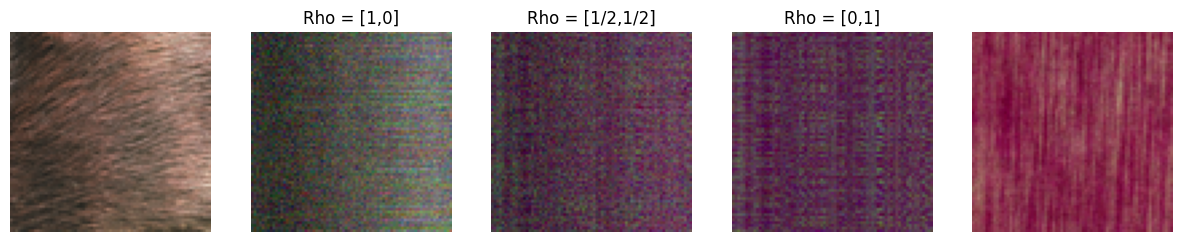

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Affiche image1
plt.subplot(1, 5, 1)
plt.imshow(image1)
plt.axis('off')  # Masquer les axes

# Affiche Y_1 avec le titre
plt.subplot(1, 5, 2)
plt.imshow(Y_1)
plt.title("Rho = [1,0]")
plt.axis('off')

# Affiche Y avec le titre
plt.subplot(1, 5, 3)
plt.imshow(Y)
plt.title("Rho = [1/2,1/2]")
plt.axis('off')

# Affiche Y_0 avec le titre
plt.subplot(1, 5, 4)
plt.imshow(Y_0)
plt.title("Rho = [0,1]")
plt.axis('off')

# Affiche image2
plt.subplot(1, 5, 5)
plt.imshow(image2)
plt.axis('off')

plt.show()


In [13]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'
size = 200
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

> En augmentant le nombre de pixels, on doit augmenter le nombre d'itérations 
## Test de différents nombre d'itérations pour le calcul du barycentre 

plus on augmente le nombre d'itérations, plus les pixels "correspondent" bien

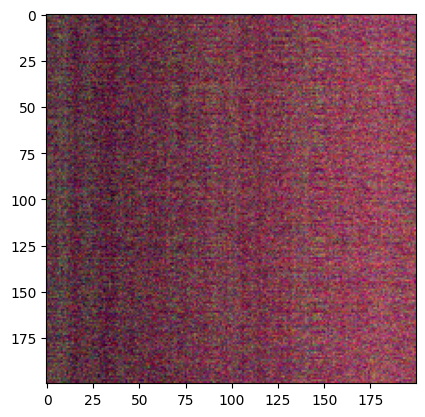

In [18]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=7000)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=7000)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=7000)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

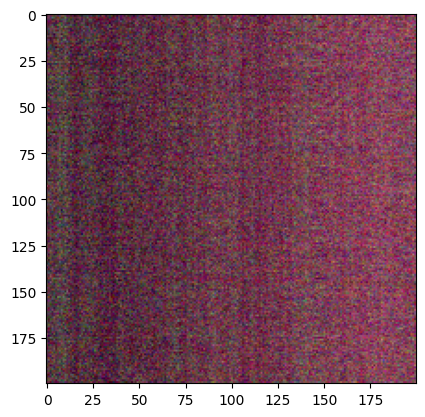

In [14]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=5000)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=5000)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=5000)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

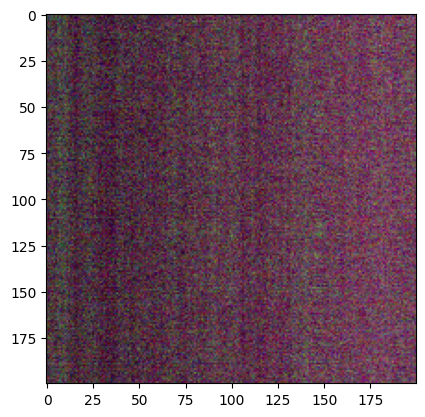

In [15]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=4000)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=4000)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=4000)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

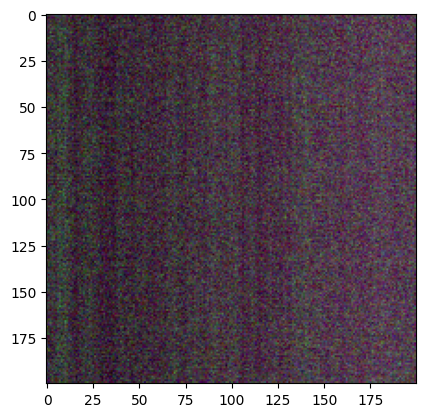

In [16]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=3000)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=3000)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=3000)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

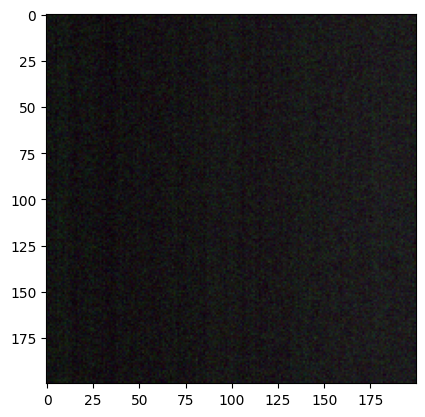

In [17]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=1000)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=1000)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=1000)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
Y = np.clip(Y, 0, 255).astype(np.uint8)
plt.imshow(Y)

## ==> 5000 itérations semblent OK

# 2 - Test des Y_l 

Calcul des Y_l 

In [19]:
def compute_steerable_pyramid_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute steerable pyramid coefficients with specified orientations using pyrtools.
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - coeffs: Dictionary of coefficients organized by scale and orientation.
    """
    # Initialize the steerable pyramid
    pyramid = pt.pyramids.SteerablePyramidFreq(image, height=num_scales, order=num_orientations-1)

    return pyramid.pyr_coeffs, pyramid

In [20]:
def compute_3D_wavelets_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute wavelets coefficients (highpass, bandpass, low-residuals) for the 3 channels (R,G,B) of an image
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - wavelets_coeffs: Dictionary of coefficients organized by channel (R,G,B) and then by bandpass (highpass, bandpass -scale and orientation- and low residual).
    """
    wavelets_coeffs = {}
    rgb = ['R','G','B']
    for channel in range(3):
        wavelets_coeffs[rgb[channel]], _ = compute_steerable_pyramid_coeffs(image[:, :, channel], num_scales=num_scales, num_orientations=num_orientations)
    return(wavelets_coeffs)

# Cleancode 

In [21]:
def compute_Y_l(image1, image2, rho=None):
    # Calcul des Y_l_1 et Y_l_2
    wavelet_coefs_1 = compute_3D_wavelets_coeffs(image1, num_scales=4, num_orientations=4)
    wavelet_coefs_1 = flatten_dict(wavelet_coefs_1)

    wavelet_coefs_2 = compute_3D_wavelets_coeffs(image2, num_scales=4, num_orientations=4)
    wavelet_coefs_2 = flatten_dict(wavelet_coefs_2)

    # Calcul des Y_l
    Y_l =  {}
    for key in tqdm(wavelet_coefs_1.keys()): 
        textures = [wavelet_coefs_1[key], wavelet_coefs_2[key]]
        Y_l[key] = compute_sliced_wass_barycenter([x for x in textures], rho=rho, nb_iter_max=1000)
    Y_l = flatten_dict(Y_l) 
    return Y_l

def compute_Y(textures, rho=None):
    Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=rho, nb_iter_max=1000)
    Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=rho, nb_iter_max=1000)
    Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=rho, nb_iter_max=1000)
    Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
    return Y

In [22]:
def from_one_dict_to_three_dic(dic):
    dic_r, dic_g, dic_b = {}, {}, {}

    # Remplir les dictionnaires en fonction du préfixe des clés
    for key, value in dic.items():
        if key.startswith('R.'):
            dic_r[key[2:]] = value  # Retirer le préfixe 'R.' et ajouter au dictionnaire dic_r
        elif key.startswith('G.'):
            dic_g[key[2:]] = value  # Retirer le préfixe 'G.' et ajouter au dictionnaire dic_g
        elif key.startswith('B.'):
            dic_b[key[2:]] = value
    return dic_r, dic_g, dic_b

def reconstruct_single_channel(channel_coeffs, original_image_shape):
    """
    Reconstruit une seule image de canal à partir des coefficients pyramidaux.

    Paramètres :
    - channel_coeffs : dictionnaire de coefficients pour un canal de couleur spécifique.
    - original_image_shape : forme de l'image originale pour initialiser la pyramide.

    Retour :
    - image reconstruite pour le canal.
    """
    # Créer une image vide pour initialiser la pyramide
    dummy_image = np.zeros(original_image_shape)

    # Construire la pyramide steerable pour le canal spécifique
    pyramid = pt.pyramids.SteerablePyramidSpace(dummy_image, height=4, order=3)
    
    # Mettre à jour les coefficients de la pyramide
    pyramid.pyr_coeffs = channel_coeffs
    
    # Reconstruire le canal de couleur à partir des coefficients
    channel_reconstructed = pyramid.recon_pyr()
    
    channel_reconstructed = np.clip(channel_reconstructed, 0, 255)
    
    return channel_reconstructed

# def texture_synthesis(model_distributions, target_pixel_distribution, size, nb_iter_max_proj=1000, num_iterations=2):
#     # Démarrer avec une image bruitée initiale
#     f_k = np.random.randn(size, size, 3)

#     for k in range(num_iterations):
#         # Étape 1 : calculer les coefficients pyramidaux steerables
#         pyramid_coeffs = compute_3D_wavelets_coeffs(f_k, num_scales=4, num_orientations=4)
#         pyramid_coeffs = flatten_dict(pyramid_coeffs)
        
#         # Étape 2 : appliquer les contraintes de distribution par projection ==> CALCUL DES C_L_N
#         for key in tqdm(pyramid_coeffs.keys()):  # Pour chaque échelle et orientation
#             target_dist = model_distributions[key]
#             current_dist = pyramid_coeffs[key]
            
#             # Projeter les coefficients de l'échelle l vers la distribution cible
#             projected_coeffs = projection(current_dist, target_dist, nb_iter_max=nb_iter_max_proj)
#             pyramid_coeffs[key] = projected_coeffs
        
#         # Étape 3 : calcul de f tilde 
#         pyr_coeffs_r, pyr_coeffs_g, pyr_coeffs_b = from_one_dict_to_three_dic(pyramid_coeffs)

#         pyr_coeffs_r = {eval(k) if '(' in k else k: v for k, v in pyr_coeffs_r.items()}
#         pyr_coeffs_g = {eval(k) if '(' in k else k: v for k, v in pyr_coeffs_g.items()}
#         pyr_coeffs_b = {eval(k) if '(' in k else k: v for k, v in pyr_coeffs_b.items()}

#         noise = np.random.randn(size, size)
#         noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise, height=4, order=3)

#         noisy_pyr.pyr_coeffs = pyr_coeffs_r
#         reconstructed_pyr_r = noisy_pyr.recon_pyr()
#         noisy_pyr.pyr_coeffs = pyr_coeffs_g
#         reconstructed_pyr_g = noisy_pyr.recon_pyr()
#         noisy_pyr.pyr_coeffs = pyr_coeffs_b
#         reconstructed_pyr_b = noisy_pyr.recon_pyr()

#         reconstructed_image = np.stack([reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b], axis=-1)
#         plt.imshow(np.clip(reconstructed_image, 0, 255).astype(np.uint8))
#         plt.show()
        
#         # Étape 4 : reconstruction de l'image en projetant 
#         f_k_r = projection(reconstructed_image[:,:,0], target_pixel_distribution[:,:,0], nb_iter_max=nb_iter_max_proj)
#         f_k_g = projection(reconstructed_image[:,:,1], target_pixel_distribution[:,:,1], nb_iter_max=nb_iter_max_proj)
#         f_k_b = projection(reconstructed_image[:,:,2], target_pixel_distribution[:,:,2], nb_iter_max=nb_iter_max_proj)

#         # peut-être changer en f_k = projection(reconstructed_image.reshape(-1,3), Y.reshape(-1,3)).reshape((size,size,3))

#         f_k = np.stack([f_k_r, f_k_g, f_k_b], axis=-1)
#         f_k_image = np.clip(f_k, 0, 255).astype(np.uint8) # assure que les valeurs sont comprises entre 0 et 255 et sont des entiers
#         # plt.imshow(f_k_image)
#         # plt.show()

#     return f_k_image


In [77]:
from joblib import Parallel, delayed
from tqdm import tqdm


def texture_synthesis(model_distributions, target_pixel_distribution, size, nb_iter_max_proj=1000, num_iterations=2):
    # Démarrer avec une image bruitée initiale
    f_k = np.random.randn(size, size, 3)

    for k in range(num_iterations):
        # Étape 1 : calculer les coefficients pyramidaux steerables
        pyramid_coeffs = compute_3D_wavelets_coeffs(f_k, num_scales=4, num_orientations=4)
        pyramid_coeffs = flatten_dict(pyramid_coeffs)
        
        # Étape 2 : appliquer les contraintes de distribution par projection ==> CALCUL DES C_L_N
        # Utiliser Parallel pour paralléliser les calculs
        results = Parallel(n_jobs=-1)(
            delayed(process_projection)(key, pyramid_coeffs[key], model_distributions[key], nb_iter_max_proj)
            for key in tqdm(pyramid_coeffs.keys())
        )

        # Mettre à jour pyramid_coeffs avec les résultats
        for key, projected_coeffs in results:
            pyramid_coeffs[key] = projected_coeffs
                
        # Étape 3 : calcul de f tilde 
        pyr_coeffs_r, pyr_coeffs_g, pyr_coeffs_b = from_one_dict_to_three_dic(pyramid_coeffs)

        pyr_coeffs_r = {eval(k) if '(' in k else k: v for k, v in pyr_coeffs_r.items()}
        pyr_coeffs_g = {eval(k) if '(' in k else k: v for k, v in pyr_coeffs_g.items()}
        pyr_coeffs_b = {eval(k) if '(' in k else k: v for k, v in pyr_coeffs_b.items()}

        noise = np.random.randn(size, size)
        noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise, height=4, order=3)

        noisy_pyr.pyr_coeffs = pyr_coeffs_r
        reconstructed_pyr_r = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyr_coeffs_g
        reconstructed_pyr_g = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyr_coeffs_b
        reconstructed_pyr_b = noisy_pyr.recon_pyr()

        reconstructed_image = np.stack([reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b], axis=-1)
        # plt.imshow(np.clip(reconstructed_image, 0, 255).astype(np.uint8))
        # plt.show()
        
        # Étape 4 : reconstruction de l'image en projetant 
        f_k_r = projection(reconstructed_image[:,:,0], target_pixel_distribution[:,:,0], nb_iter_max=nb_iter_max_proj)
        f_k_g = projection(reconstructed_image[:,:,1], target_pixel_distribution[:,:,1], nb_iter_max=nb_iter_max_proj)
        f_k_b = projection(reconstructed_image[:,:,2], target_pixel_distribution[:,:,2], nb_iter_max=nb_iter_max_proj)

        # peut-être changer en f_k = projection(reconstructed_image.reshape(-1,3), Y.reshape(-1,3)).reshape((size,size,3))

        f_k = np.stack([f_k_r, f_k_g, f_k_b], axis=-1)
        f_k_image = np.clip(f_k, 0, 255).astype(np.uint8) # assure que les valeurs sont comprises entre 0 et 255 et sont des entiers
        plt.imshow(f_k_image)
        plt.show()

    return f_k_image


# Définir une fonction pour traiter chaque élément de la boucle
def process_projection(key, current_dist, target_dist, nb_iter_max_proj):
    return key, projection(current_dist, target_dist, nb_iter_max=nb_iter_max_proj)

## Test avec 200 pixels (200,200) : plus long que 75 voir en bas et pour l'instant pas bons résultats 

In [65]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'
size = 200
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

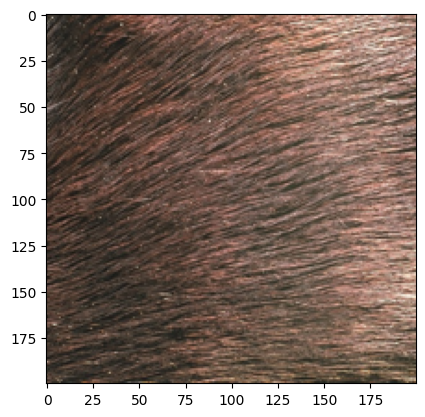

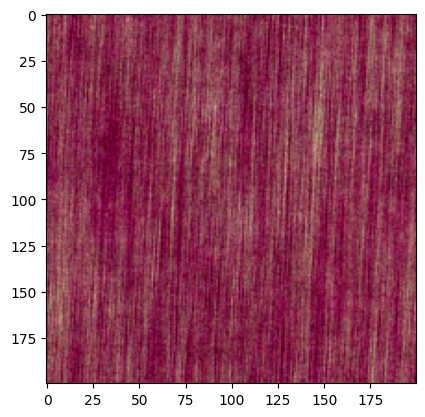

In [66]:
plt.imshow(image1)
plt.show()
plt.imshow(image2)

In [67]:
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_Y_l_bis(image1, image2, rho=None, nb_iter_max=1000):
    # Calcul des Y_l_1 et Y_l_2
    wavelet_coefs_1 = compute_3D_wavelets_coeffs(image1, num_scales=4, num_orientations=4)
    wavelet_coefs_1 = flatten_dict(wavelet_coefs_1)

    wavelet_coefs_2 = compute_3D_wavelets_coeffs(image2, num_scales=4, num_orientations=4)
    wavelet_coefs_2 = flatten_dict(wavelet_coefs_2)

    # Calcul des Y_l en parallèle
    def compute_barycenter_for_key(key):
        textures = [wavelet_coefs_1[key], wavelet_coefs_2[key]]
        return key, compute_sliced_wass_barycenter(textures, rho=rho, nb_iter_max=nb_iter_max)
    
    results = Parallel(n_jobs=-1)(delayed(compute_barycenter_for_key)(key) for key in tqdm(wavelet_coefs_1.keys()))
    
    Y_l = {key: result for key, result in results}
    Y_l = flatten_dict(Y_l)
    return Y_l

def compute_Y_bis(textures, rho=None, nb_iter_max=1000):
    # Calcul de chaque canal en parallèle
    def compute_barycenter_channel(channel_data):
        return compute_sliced_wass_barycenter(channel_data, rho=rho, nb_iter_max=nb_iter_max)

    Y_r, Y_g, Y_b = Parallel(n_jobs=-1)(
        delayed(compute_barycenter_channel)([x[:, :, c] for x in textures]) for c in range(3)
    )
    
    Y = np.stack((Y_r, Y_g, Y_b), axis=-1)
    return Y


In [69]:
textures = [image1, image2]
Y_l = compute_Y_l_bis(image1, image2, rho=[1/2,1/2], nb_iter_max=5000)
Y = compute_Y_bis(textures, rho=[1/2,1/2], nb_iter_max=7000)




/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/

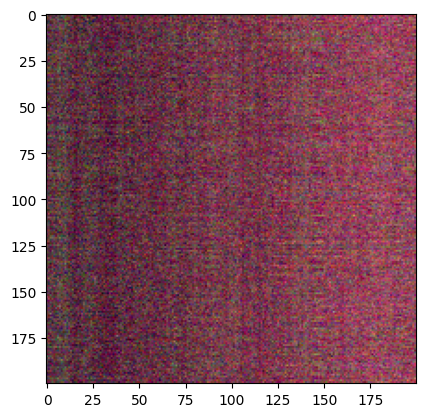

In [70]:
plt.imshow(np.clip(Y,0,255).astype(np.uint8))
plt.show()








100%|██████████| 54/54 [01:27<00:00,  1.62s/it]


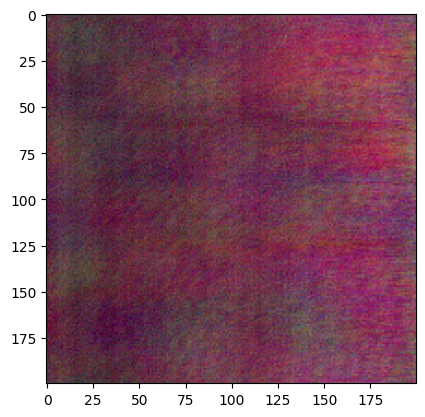







100%|██████████| 54/54 [01:30<00:00,  1.67s/it]


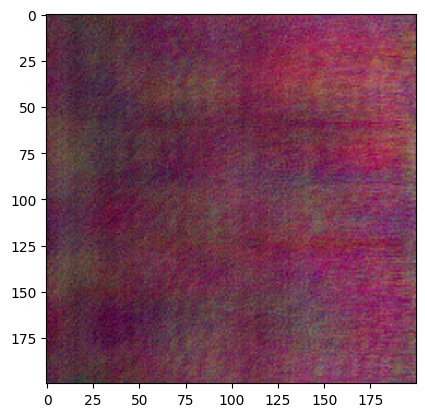







100%|██████████| 54/54 [01:29<00:00,  1.67s/it]


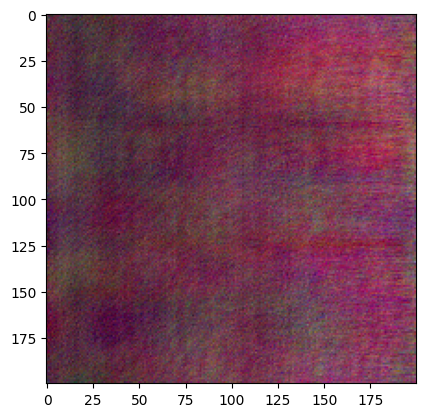

In [71]:
target_pixel_distribution = Y
model_distributions = Y_l
f_k_image = texture_synthesis(model_distributions, target_pixel_distribution, size, nb_iter_max_proj=5000, num_iterations=3)

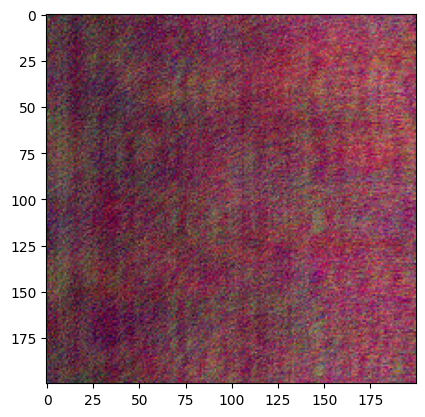

In [72]:
plt.imshow(f_k_image)

# Test avec 75 pixels : OK 

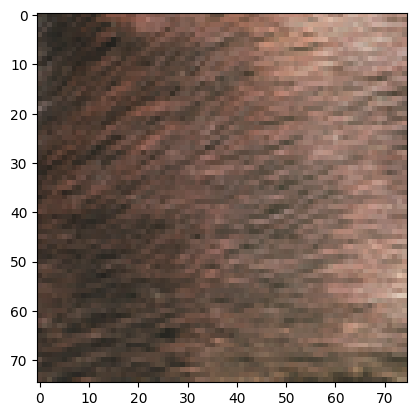

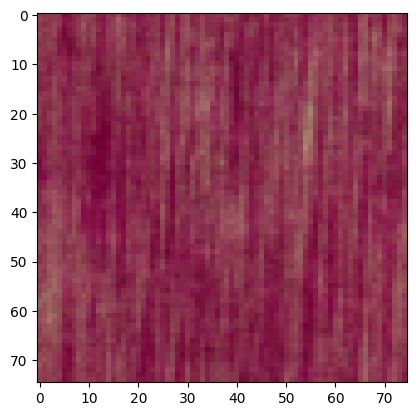

100%|██████████| 54/54 [00:18<00:00,  2.93it/s]


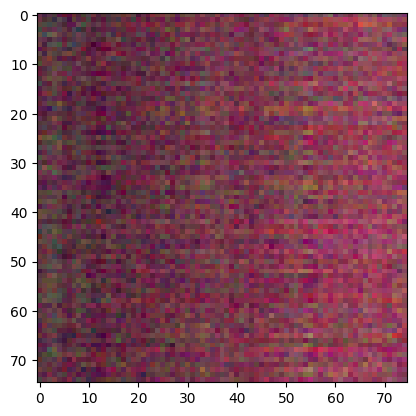

In [51]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'
size = 75
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

textures = [image1, image2]
Y_l = compute_Y_l_bis(image1, image2, rho=[1/2,1/2], nb_iter_max=1000)
Y = compute_Y_bis(textures, rho=[1/2,1/2], nb_iter_max=1000)

plt.imshow(np.clip(Y,0,255).astype(np.uint8))
plt.show()

100%|██████████| 54/54 [00:09<00:00,  5.47it/s]


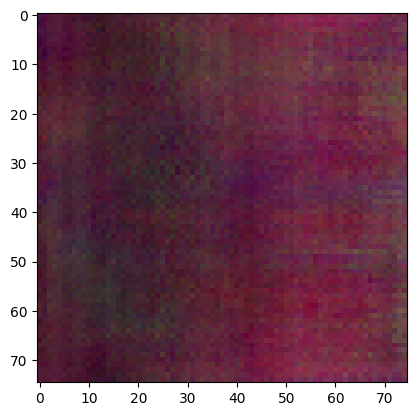

In [52]:
target_pixel_distribution = Y
model_distributions = Y_l 
f_k_image = texture_synthesis(model_distributions, target_pixel_distribution, size, nb_iter_max_proj=1000, num_iterations=1)

### Test avec d'autres textures :

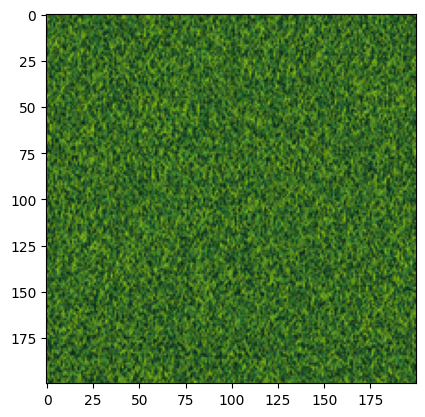

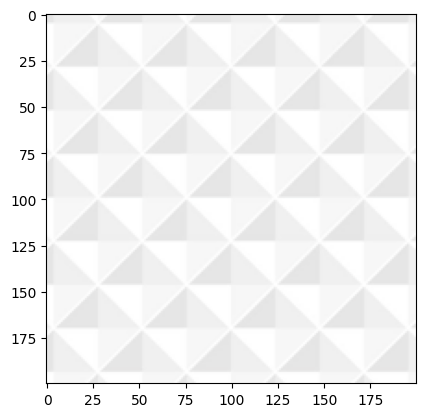



/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/t

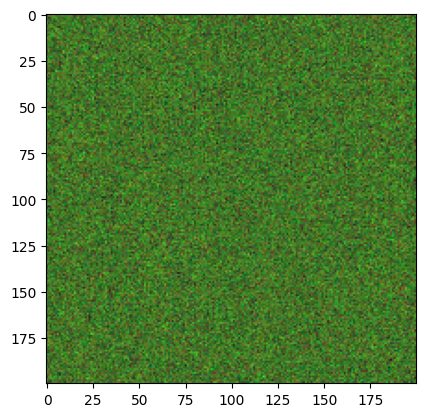

In [74]:
image_path1 = 'data/grass.jpg'
image_path2 = 'data/texture1.png'
size = 200
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

textures = [image1, image2]
Y_l = compute_Y_l_bis(image1, image2, rho=[1/2,1/2], nb_iter_max=10000)
Y = compute_Y_bis(textures, rho=[1/2,1/2], nb_iter_max=10000)

plt.imshow(np.clip(Y,0,255).astype(np.uint8))
plt.show()







/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/jobl

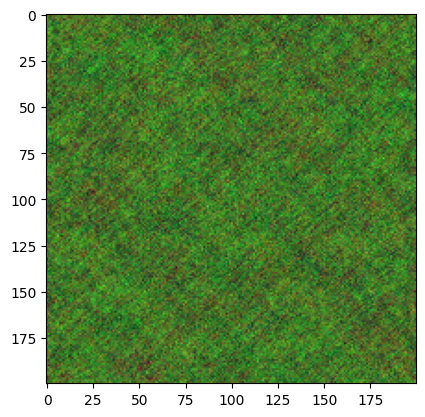













100%|██████████| 54/54 [03:28<00:00,  3.87s/it]


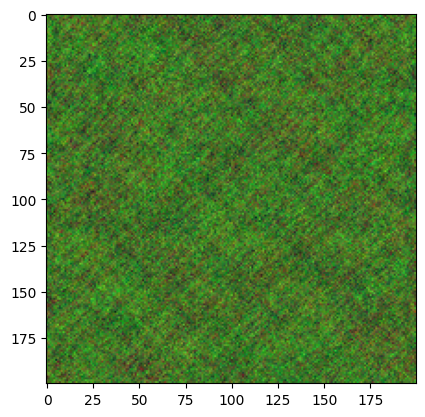













100%|██████████| 54/54 [03:30<00:00,  3.90s/it]


KeyboardInterrupt: 

In [78]:
target_pixel_distribution = Y
model_distributions = Y_l 
f_k_image = texture_synthesis(model_distributions, target_pixel_distribution, size, nb_iter_max_proj=10000, num_iterations=3)

### Plots all 

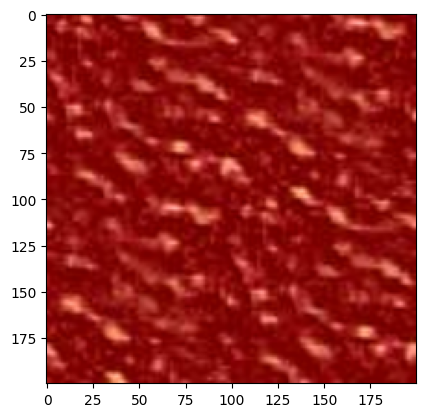

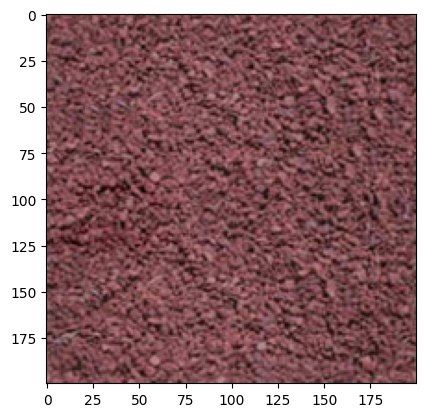



















/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://git

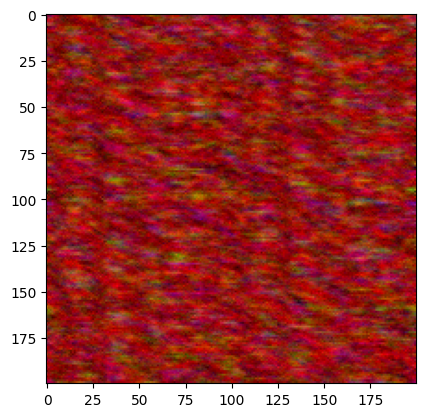


































100%|██████████| 54/54 [08:00<00:00,  8.90s/it]










/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. 

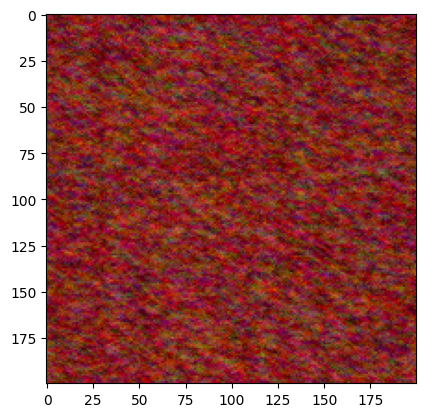


































100%|██████████| 54/54 [06:05<00:00,  6.77s/it]






























100%|██████████| 54/54 [03:31<00:00,  3.91s/it]


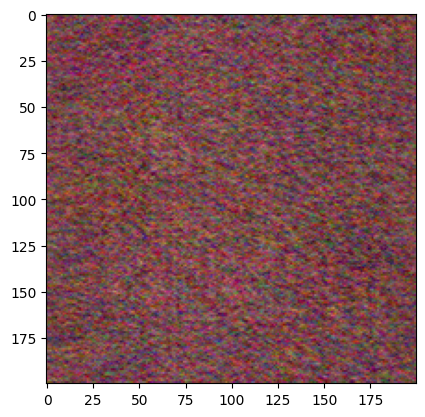




3it [1:46:40, 2133.59s/it]


In [83]:
image_path1 = 'data/smallRed.jpg'
image_path2 = 'data/PebbleGround.png'
size = 200
image1 = preprocess_image(image_path1, new_size = (size,size))
image2 = preprocess_image(image_path2, new_size = (size,size))
textures = [image1, image2]

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

textures = [image1, image2]

rho_values = [[3/4, 1/4], [1/2, 1/2], [1/4, 3/4]]

final_texture = []
# Boucle sur les valeurs de `rho` pour afficher les images générées
for i, rho in tqdm(enumerate(rho_values, start=1)):
    # Calcul des distributions et de la texture synthétisée
    Y_l = compute_Y_l_bis(image1, image2, rho=rho, nb_iter_max=10000)
    Y = compute_Y_bis(textures, rho=rho, nb_iter_max=10000)
    target_pixel_distribution = Y
    model_distributions = Y_l
    f_k_image = texture_synthesis(model_distributions, target_pixel_distribution, size, nb_iter_max_proj=10000, num_iterations=1)
    
    final_texture.append(f_k_image)

Text(0.5, 1.0, 'Original $f^2$')

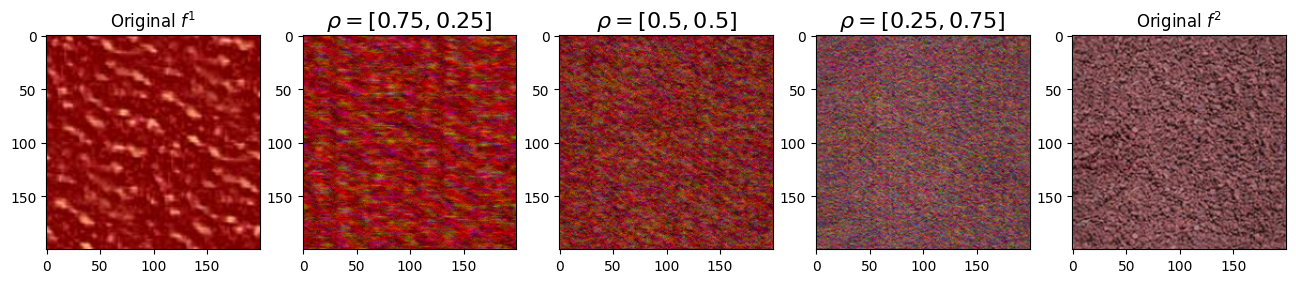

In [86]:
plt.figure(figsize=(16, 8))
plt.subplot(1,5,1)
plt.imshow(image1)
plt.title('Original $f^1$')
for i in range(len(final_texture)):
    plt.subplot(1,5,i+2)
    plt.imshow(final_texture[i])
    plt.title(f'$\\rho = {rho_values[i]}$', fontsize=16)
plt.subplot(1,5,5)
plt.imshow(image2)
plt.title('Original $f^2$')